# Lab. 7 - Variable selection

## Hesam Mohebi

In this lab we will move to considering the problems of variable selection in classification (thus supervised) scenarios.

As usual, we start importing libraries and functions already used in one of the previous labs.

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.linalg as la

rnd_state = np.random.RandomState(12)

### Data generation

To generate a synthetic dataset suitable for use with variable selection, we first generate a subset of "relevant" features, and then concatenate with a second set of "dummy", irrelevant featuers. To this purpose,  we proceed as follows:
- Generate a dataset with the `mixGauss` function: use two Gaussians which are *close* with each other (see example below). Start by considering 2-Dimensional points
- Plot the points: you should observe two point-clouds which mix with each other (since they were generated with the same parameters).
- Enrich the input samples with "dummy" features randomly sampled and concatenate to the relevant features (notice that at this point data visualization is no more possible


In [2]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = rnd_state.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

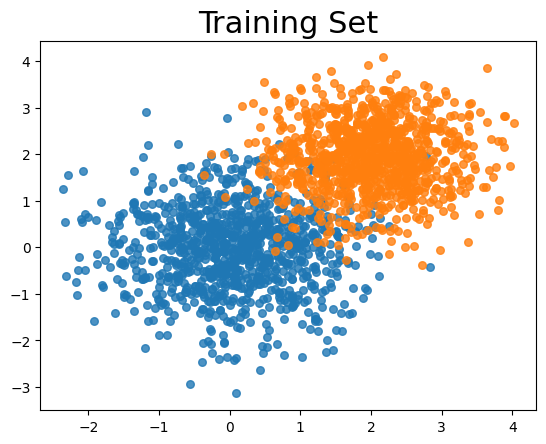

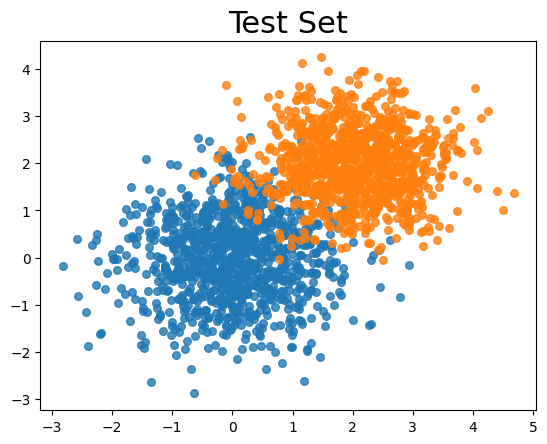

In [9]:
n=1000 # number of features for each gaussian
d=30 # total number of features
d_rev = 2 # number of relevant features

Xtr, Ytr = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)
Xte, Yte = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)

# plot
fig, ax = plt.subplots()
ax.set_title("Training Set", fontsize=22)
ax.scatter(Xtr[Ytr==-1,0], Xtr[Ytr==-1,1], s=30, alpha=0.80)
ax.scatter(Xtr[Ytr==1,0], Xtr[Ytr==1,1], s=30, alpha=0.80)


fig, ax = plt.subplots()
ax.set_title("Test Set", fontsize=22)
ax.scatter(Xte[Yte==-1,0], Xte[Yte==-1,1], s=30, alpha=0.80)
ax.scatter(Xte[Yte==1,0], Xte[Yte==1,1], s=30, alpha=0.80)

In [38]:
# dummy features generation
sigma_noise = 0.13
Xtr_noise = sigma_noise * rnd_state.randn(2*n, d-d_rev)
Xtr = np.concatenate((Xtr,Xtr_noise), axis=1)
Xte_noise = sigma_noise * rnd_state.randn(2*n, d-d_rev)
Xte = np.concatenate((Xte,Xte_noise), axis=1)

In [39]:
Xtr.shape

(2000, 30)

In [40]:
import pandas as pd

Xtr_df = pd.DataFrame(Xtr)
Xtr_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.388755,-2.471207,-0.048776,0.007827,-0.171884,0.111633,-0.161605,0.003368,-0.430524,-0.090912,...,-0.193154,0.159161,-0.147452,-0.000122,-0.087925,0.064100,0.136190,0.150434,0.009494,-0.026190
1,-0.062071,-0.790049,-0.064903,-0.046514,-0.076251,-0.141142,0.267969,0.129855,-0.133833,-0.214942,...,0.083881,-0.183002,0.139717,-0.136444,0.027842,-0.003385,-0.205154,0.089665,-0.203330,0.039546
2,-0.477255,0.106252,0.204193,-0.147398,0.014822,-0.243515,0.006782,-0.079822,0.012566,0.256722,...,-0.304004,-0.011824,0.018559,0.032052,0.055071,-0.018393,-0.179190,0.035225,-0.040693,0.089457
3,0.244221,0.591625,0.116569,0.114078,-0.036852,-0.056935,0.001779,-0.008058,0.022013,0.308913,...,0.100145,0.122624,0.150921,-0.065325,0.107270,0.085287,-0.053153,-0.035912,0.158397,-0.157268
4,-1.298554,0.723396,-0.035184,-0.012208,0.090809,-0.120657,0.133436,0.031522,-0.040990,0.042061,...,0.067831,-0.011066,-0.026944,0.054320,0.060841,-0.067917,0.140304,0.013592,0.108822,-0.081924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.073409,2.013355,-0.087677,-0.014474,0.075377,-0.151092,-0.197044,0.011237,0.007540,-0.049844,...,0.024147,0.063663,-0.031339,0.098505,0.003452,-0.051326,-0.302451,0.258452,0.055845,-0.075790
1996,2.479083,2.945864,-0.187085,-0.041808,0.040997,0.028456,-0.059264,-0.211184,-0.049044,0.072074,...,-0.002474,0.168858,-0.071466,0.086071,0.280298,0.087163,0.042868,0.327405,-0.153191,-0.044900
1997,2.223629,2.152971,-0.153408,0.075838,0.053044,0.033839,-0.081824,-0.023624,-0.005894,-0.050623,...,-0.033861,-0.008376,0.147146,0.107840,0.198363,0.187456,-0.054097,-0.165512,-0.178403,-0.191548
1998,1.541611,2.249642,0.049079,0.031555,-0.117873,0.154200,-0.242949,0.048543,-0.116675,0.013349,...,-0.189070,-0.075534,-0.211465,0.104619,-0.048673,-0.047150,-0.110044,0.047166,0.207918,0.060640


## Variable selection

##### OMatchingPursuit

It computes a sparse representation of the signal using Orthogonal Matching Pursuit algorithm. Use it as follows:
    
`w, r, I = OMatchingPursuit( X, Y, T)`

where
    - X: input data
    - Y: output labels
    - T: number of iterations
    - w: estimated coefficients
    - r: residuals
    - I: indices


In [41]:
def OMatchingPursuit(X, Y, T):

    N, D = np.shape(X)

    # 1. Initialization of residual, coefficient vector and index set I
    r = Y
    w = np.zeros(D)
    I = []

    for i in range(T):
        I_tmp = range(D)

        # 2. Select the column of X which coefficients most "explains" the residual
        a_max = -1

        for j in I_tmp:
            a_tmp = abs(X[:, j].dot(r)) # computing the correlation between X[j] and residual r
        
            if a_tmp > a_max:
                a_max = a_tmp
                j_max = j

        # 3. Add the index to the set of indexes
        if j_max not in I:
            I.append(j_max)

        # Compute the M matrix
        M_I = np.zeros((D, D))

        for j in I:
            M_I[j, j] = 1

        A = M_I.dot(X.T).dot(X).dot(M_I)
        B = M_I.dot(X.T).dot(Y)

        # 4. Update estimated coefficients
        w = np.linalg.lstsq(A, B, rcond=None)[0] #  least-squares solver that can handle rank-deficient problems


        # 5. Update the residual
        r = Y - X.dot(w)

    return w, r, I

In [42]:
# Usual function to compute the error in predicted labels (for a binary classification problem)
def calcError(Ypred, Y):
    V = np.multiply(np.sign(Ypred), np.sign(Y))
    return np.count_nonzero(V < 0) / len(Y)

In [43]:
# K-Fold Cross Validation for selecting the best value for the hyperparameters in the use of 
# Orthogonal Matching Pursuit (we refer to the number of iterations)

def KFoldCVOMP(Xtr, Ytr, KF, niter_list):
    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    niter_list = np.array(niter_list)
    num_niter = niter_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.floor(n_tot/KF))

    Tm = np.zeros(num_niter)
    Ts = np.zeros(num_niter)
    Vm = np.zeros(num_niter)
    Vs = np.zeros(num_niter)

    # Random permutation of training data
    rand_idx = rnd_state.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, niter in enumerate(niter_list):
        first = 0
        for fold in range(KF):
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # Compute the training error of OMP for the given number of iterations
            w, r, I = OMatchingPursuit(X, Y, niter)
            YpredTR = np.sign(X.dot(w))
            trError = calcError(YpredTR, Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error OMP for the given number of iterations
            YpredVAL = np.sign(X_val.dot(w))
            valError = calcError(YpredVAL, Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_niter_idx = np.argmin(Vm)
    bestniter = niter_list[best_niter_idx]
    
    print(Vm)
    print(niter_list)
    print(best_niter_idx)

    return bestniter, Vm, Vs, Tm, Ts

### Some analysis

We suggest to proceed as follows:

- Standardize the data
- Run Orthogonal Matching Pursuit on the training set setting a reasonable number of iterations
- Compute the prediction on the test set and evaluate the error
- Plot the components of the solution w (considering their absolute value): how do they look?
- Run the K-Fold Cross Validation to select an appropriate value for the number of iterations


In [44]:
# Data standardization
m = np.mean(Xtr, axis=0)
s = np.std(Xtr, axis=0)
Xtrnorm = np.divide((Xtr - m), s)
Xtenorm = np.divide((Xte - m), s)

Test error: 0.042


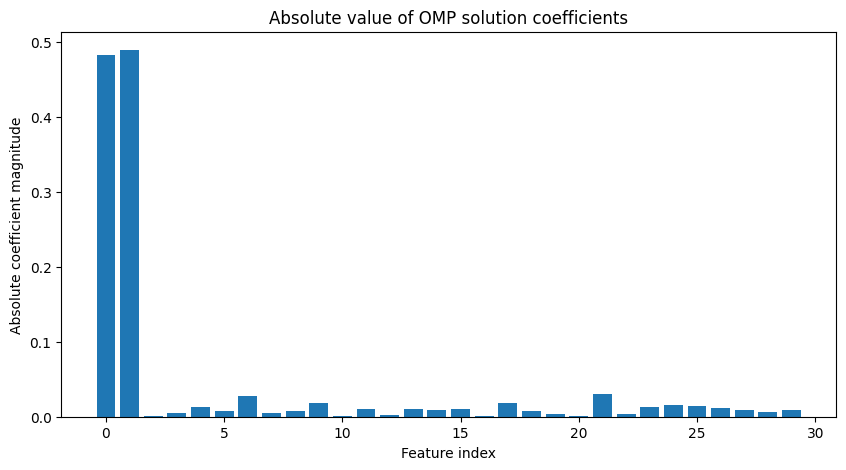

In [49]:
# Run Orthogonal Matching Pursuit
w, r, I = OMatchingPursuit(Xtrnorm, Ytr, 100)

# Compute the prediction on the test set
Ypred_test = np.sign(Xtenorm.dot(w))
# Compute the test error and show its value
test_error = calcError(Ypred_test, Yte)
print("Test error:", test_error)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(w)), np.abs(w))
plt.xlabel('Feature index')
plt.ylabel('Absolute coefficient magnitude')
plt.title('Absolute value of OMP solution coefficients')
plt.show()

from the plot it is visible that the first two absoulutecoefficient magnitudes are much higher than other features indicating their correlation to the labels. This aligns with the sparsity property of the Orthogonal Matching persuit, which select only a small subset of features.

[0.122  0.0435 0.043  0.043  0.043  0.0425 0.0455]
[ 1  2  3  4  5 10 30]
5
Best number of iterations: 10


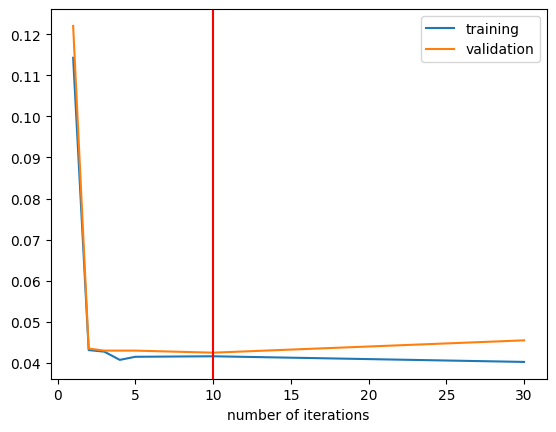

In [51]:
# run K-Fold Cross Validation
KF = 5
niter_list = [1, 2, 3, 4, 5, 10, d] 
bestniter, Vm, Vs, Tm, Ts = KFoldCVOMP(Xtrnorm, Ytr, KF, niter_list)

# Plot training and validation error
plt.subplots()
plt.plot(niter_list, Tm, label="training")
plt.plot(niter_list, Vm, label="validation")
plt.legend(loc="best")
plt.xlabel("number of iterations")
plt.axvline(bestniter, color="red")
print('Best number of iterations: '+str(bestniter))

-   From this plot we can observe that both validation adn training error drops sharply withing the second and third number of iterations.Then after 10 iterations, the validation error starts to increase gradually.
-   The initial decrease in validation error suggests that the model learns relevant patterns effectively for the first few iterations.
-   Beyond 10 iterations, the validation error starts increasing, indicating potential overfitting as the model becomes more specialized to the training data.

We can also shuffle columns of the synthetic dataset in order to observe the behavior of OMP

In [52]:
# Shuffle columns
shuffle_idx = rnd_state.choice(Xtr.shape[1], Xtr.shape[1], replace=False)

Xtr = Xtr[:, shuffle_idx]
Xte = Xte[:, shuffle_idx]

In [53]:
print("[--] The relevant features are {} and {}".format((shuffle_idx == 0).argmax(), (shuffle_idx == 1).argmax() ))

[--] The relevant features are 6 and 24


Test error: 0.042


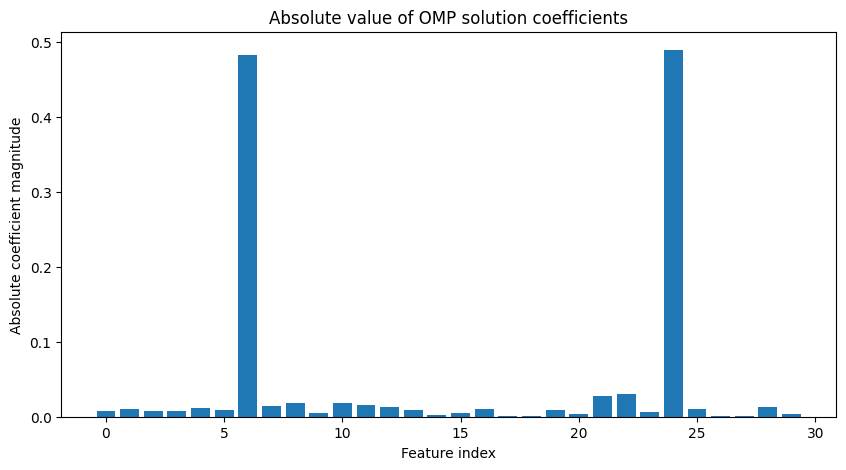

In [54]:
# Run OMP and verify that it is able to find the relevant features

# Run Orthogonal Matching Pursuit

# Data standardization
m = np.mean(Xtr, axis=0)
s = np.std(Xtr, axis=0)
Xtrnorm = np.divide((Xtr - m), s)
Xtenorm = np.divide((Xte - m), s)

w, r, I = OMatchingPursuit(Xtrnorm, Ytr, 100)

# Compute the prediction on the test set
Ypred_test = np.sign(Xtenorm.dot(w))
# Compute the test error and show its value
test_error = calcError(Ypred_test, Yte)
print("Test error:", test_error)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(w)), np.abs(w))
plt.xlabel('Feature index')
plt.ylabel('Absolute coefficient magnitude')
plt.title('Absolute value of OMP solution coefficients')
plt.show()

As it was expected the model was able to find the same features in their new indexes. showing the correctness of the model's implementation.

Increase the number of relevant and dummy features and observe the behavior of OMP 

In [68]:
# Insert your code here
n=1000 # number of features for each gaussian
d=50 # total number of features
d_rev = 8 # number of relevant features

Xtr, Ytr = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)
Xte, Yte = mixGauss(means = [[0,0],[2,2]], sigmas = [0.9, 0.75], n=n)


# Generate new dummy features for the training and test datasets
sigma_noise = 0.13
Xtr_noise = sigma_noise * rnd_state.randn(2 * n, d-d_rev)
Xtr = np.concatenate((Xtr, Xtr_noise), axis=1)

Xte_noise = sigma_noise * rnd_state.randn(2 * n, d-d_rev)
Xte = np.concatenate((Xte, Xte_noise), axis=1)


Xte.shape

(2000, 44)

In [78]:
# Insert your code here
n = 1000  
d = 50  
d_rev = 2  #
new_relevant_features = 10  # number of additional relevant features

# Generate base dataset
Xtr, Ytr = mixGauss(means=[[0, 0], [2, 2]], sigmas=[0.9, 0.75], n=n)
Xte, Yte = mixGauss(means=[[0, 0], [2, 2]], sigmas=[0.9, 0.75], n=n)

# Generate dummy features for training and test datasets
sigma_noise = 0.13
num_dummy_features = d - d_rev
Xtr_noise = sigma_noise * rnd_state.randn(2 * n, num_dummy_features)
Xte_noise = sigma_noise * rnd_state.randn(2 * n, num_dummy_features)

# Add dummy features to the datasets
Xtr = np.concatenate((Xtr, Xtr_noise), axis=1)
Xte = np.concatenate((Xte, Xte_noise), axis=1)

# Generate new relevant features
new_Xtr_relevant = np.zeros((2 * n, new_relevant_features))
new_Xte_relevant = np.zeros((2 * n, new_relevant_features))

for i in range(new_relevant_features):
    new_Xtr_relevant[:, i] = 0.5 * Xtr[:, 0] + 0.3 * Xtr[:, 1] + 0.1 * Ytr * rnd_state.randn(2 * n)
    new_Xte_relevant[:, i] = 0.5 * Xte[:, 0] + 0.3 * Xte[:, 1] + 0.1 * Yte * rnd_state.randn(2 * n)

# Add the new relevant features to the datasets
Xtr = np.concatenate((Xtr, new_Xtr_relevant), axis=1)
Xte = np.concatenate((Xte, new_Xte_relevant), axis=1)

# Print the shapes to verify the results
print("Shape of Xtr:", Xtr.shape)
print("Shape of Xte:", Xte.shape)


Shape of Xtr: (2000, 60)
Shape of Xte: (2000, 60)


Test error: 0.045


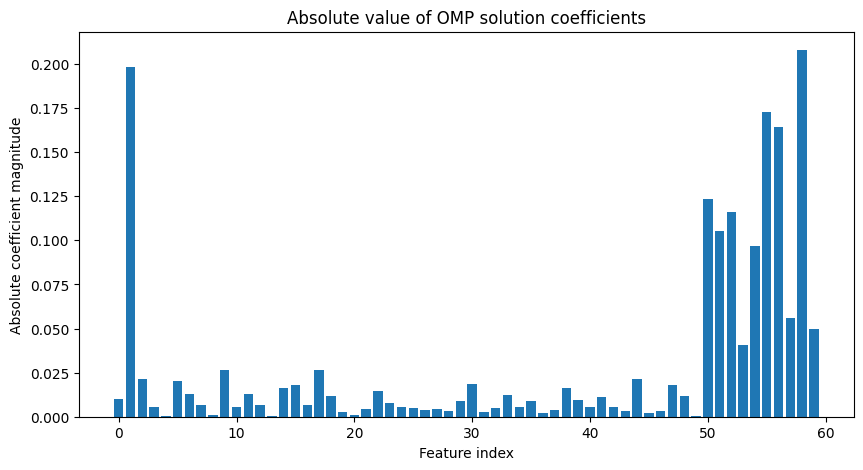

In [80]:
# Run OMP and verify that it is able to find the relevant features

# Run Orthogonal Matching Pursuit

# Data standardization
m = np.mean(Xtr, axis=0)
s = np.std(Xtr, axis=0)
Xtrnorm = np.divide((Xtr - m), s)
Xtenorm = np.divide((Xte - m), s)

w, r, I = OMatchingPursuit(Xtrnorm, Ytr, 100)

# Compute the prediction on the test set
Ypred_test = np.sign(Xtenorm.dot(w))
# Compute the test error and show its value
test_error = calcError(Ypred_test, Yte)
print("Test error:", test_error)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(w)), np.abs(w))
plt.xlabel('Feature index')
plt.ylabel('Absolute coefficient magnitude')
plt.title('Absolute value of OMP solution coefficients')
plt.show()

As it is visible in the plot 10 new featurs that has been added to the dataset are all visible since their absolute coefficient magnitudes are much higher than other features 